# Customer Churn

## Introduction
The Telco Customer Churn dataset is a fictional dataset created by the IBM Watson Analytics community and can be found on Kaggle at https://www.kaggle.com/datasets/blastchar/telco-customer-churn. The dataset contains various data on customers for an imaginary telecommunications company named Telco. The ojective it to attempt to predict whether or not customers will churn (cancel their services with the company) in the future based on various data that we have on that customers.
<br>

As the response is whether or not customers churn, we will approach this dataset with a few different categorical methods and compare how they perform against another. The models include a logistic regression model, a naive bayes model, a decision tree model and a random forests model. For each model, we will fit a full model and will also fit a reduced models using Chi2 criteria for feature selection. We'll then compare and discuss the caveats of each model.

In [1]:
import numpy as np
import pandas as pd

#import the csv
churn = pd.read_csv('Customer-Churn.csv')

# Blank total charges are replaced with None
churn.loc[churn.TotalCharges == ' ', 'TotalCharges'] = None

# We need to make sure that our data are of the right type - most are categorical but some are numeric
categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
quants = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Assign the correct datatype to both responses and predictors
churn['Churn'] = churn['Churn'].astype('category')
for i in categoricals:
    churn[i] = churn[i].astype('category')
for j in quants:
    churn[j] = churn[j].astype('float64')

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   float64 
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

## Data Description
The dataset contains 7,043 observations (with each observation corresponding to a customer) and there are a total 21 columns in the dataset, which are shown above. The first column is the customer ID, which is essentially an index and can be left alone for now. The following 19 columns contain data on various attributes of the customer and can be treated as explanatory variables (or features). The final column is customer churn, which can be treated as a binary response variable that indicates whether or not customer churn occurred. The majority (16) of the explanatory variables are categorical variables – with two to four categories each and a labeled as 'category' above while the three quantitative variables (tenure, MonthlyCharges, & TotalCharges) are labeled float 64.

<br>

We will take a machine learning approach when dealing with this dataset. We will use four classification models to predict customer churn by splitting our dataset into a training set and a testing set. We'll train each set on the training set before applying them to the testing set and compare how well each performed as well as some caveats to each model. When fitting a model, we will first fit a full model using (almost) all of the features above and we will also fit a reduced model using Chi2 criteria for feature selection (giving us a total of 8 models).

## Cleaning the data

We need to clean the data up a bit before analyzing it. We can go ahead and start of by printing out the first few lines of the dataset as well as checking the columns for NA values.

In [2]:
churn.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10.0,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62.0,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
churn.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are just 11 NAs contained in the dataset - all under TotalCharges. Looking at the first 10 rows of data, we should consider which of these features are actually important to the anlysis - some also appear they may be redundant. For example, looking at the first row, we see that this individual's tenure is 1 month and has identical values for their MonthlyCharges and TotalCharges indicating that Total Charges is likely just a function of tenure and monthly charges. If we plot TotalCharges against MonthlyCharges\*Tenure on a scatterplot, we see that the two features display a near perfect linear relationship.

The correlation coefficient between Monthly Charges times Tenure and Total Charges is 0.9996


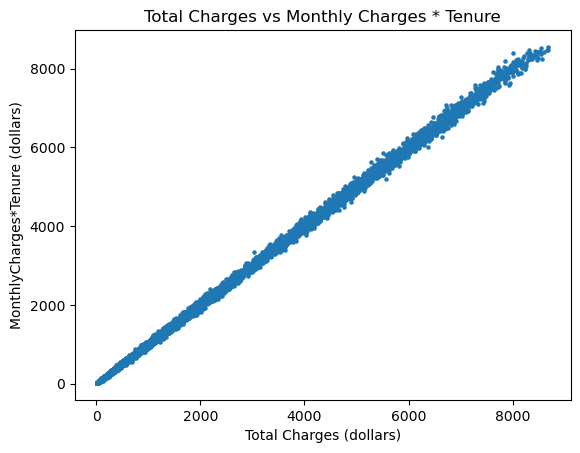

In [4]:
from matplotlib import pyplot as plt

churn_rmna = churn.dropna(axis = 0).copy()
x = churn_rmna.TotalCharges
y = churn_rmna.MonthlyCharges * churn_rmna.tenure

print('The correlation coefficient between Monthly Charges times Tenure and Total Charges is {}'.format(
    round(np.corrcoef(x, y)[0][1],4)))
plt.scatter(x, y, alpha = 1, s = 5);
plt.title("Total Charges vs Monthly Charges * Tenure")
plt.xlabel("Total Charges (dollars)")
plt.ylabel("MonthlyCharges*Tenure (dollars)");

Since this would certainly cause issues with multicollinearity, we should remove one of the variables. Since TotalCharges contains missing values and is also less informative (it's easy to determine TotalCharges from Tenure and MonthlyCharges but impossible to do the reverse) it's best get rid of it while retaining Monthly Charges and Tenure. Customer ID can also be removed as it would have no reasonable affect on whether customer churn occurs or not.

In [5]:
churn.drop(['TotalCharges', 'customerID'], axis=1, inplace = True)

In [6]:
# For consistency's sake, we will convert the 0s and 1s to No and Yes to match other categories

churn['SeniorCitizen'].replace(0, 'No', inplace = True)
churn['SeniorCitizen'].replace(1, 'Yes', inplace = True)

X = churn.iloc[:,0:18]
y = churn.iloc[:,18]

In [7]:
churn.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
5,Female,No,No,No,8.0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,Yes
6,Male,No,No,Yes,22.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,No
7,Female,No,No,No,10.0,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,No
8,Female,No,Yes,No,28.0,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,Yes
9,Male,No,No,Yes,62.0,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,No


## Data Visualization

We can explore the data a bit with some visualizations. Since the majority of the data is categorical, it makes sense to look at the proportions of individuals that land in churn or no churn over the different categories for different features (e.g. we could compare the proportion of individuals who churned/didn't by male and female to see if one gender tends to churn more than the other). We could easily create contingency tables to show these values which could be converted into stacked bar plots which make it easy to compare with feature if a possible association exists. To start, we can make some contigency tables related to demographic data on customers (gender, senior citizen status, dependents, and partner)

In [8]:
# To start, lets create some contignency tables with percentages of churn vs no churn for each of the
# demographic categories we have selected

gender_table = pd.crosstab(churn['gender'], churn['Churn'], normalize = 'index')
senior_table = pd.crosstab(churn['SeniorCitizen'], churn['Churn'], normalize = 'index')
dep_table = pd.crosstab(churn['Dependents'], churn['Churn'], normalize = 'index')
partner_table = pd.crosstab(churn['Partner'], churn['Churn'], normalize = 'index')

gender_table

Churn,No,Yes
gender,,
Female,0.730791,0.269209
Male,0.738397,0.261603


We've made tables for each of the demographic features and displayed one (for gender above). The table gives the percentages of churn for each sex and as we can see, both males and females tend to churn at nearly the same amount at around 73%, so gender is likely to not be an important feature. In order to visualize some of these better, we will make few plots below.

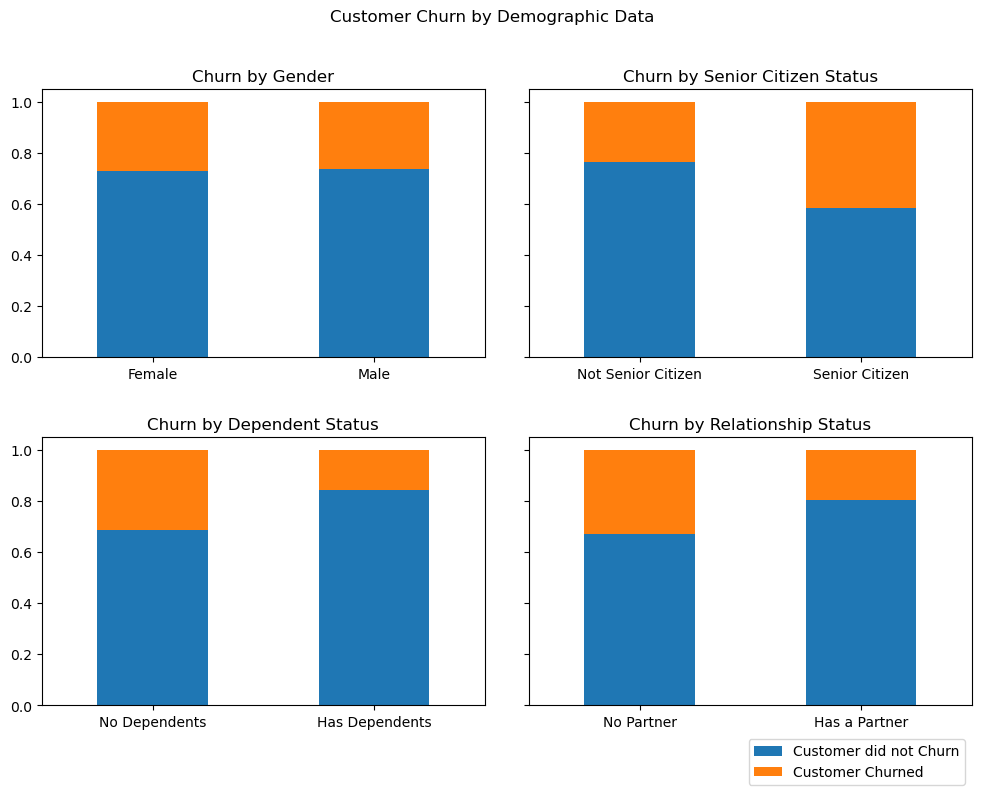

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True)
fig.suptitle('Customer Churn by Demographic Data')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.3)
plt.xticks(rotation = 45)

gender_table.reset_index().plot(ax = ax1, kind = 'bar', stacked = True,legend=None)
ax1.set_xticklabels(gender_table.index, rotation=0)
ax1.set_title('Churn by Gender')

senior_table.reset_index().plot(ax = ax2, kind = 'bar', stacked = True, legend=None)
ax2.set_xticklabels(['Not Senior Citizen', 'Senior Citizen'], rotation=0)
ax2.set_title('Churn by Senior Citizen Status')

dep_table.reset_index().plot(ax = ax3, kind = 'bar', stacked = True, legend=None)
ax3.set_xticklabels(['No Dependents', 'Has Dependents'], rotation=0)
ax3.set_title('Churn by Dependent Status')

partner_table.reset_index().plot(ax = ax4, kind = 'bar', stacked = True)
ax4.set_xticklabels(['No Partner', 'Has a Partner'], rotation=0)
ax4.set_title('Churn by Relationship Status')
ax4.legend(['Customer did not Churn', 'Customer Churned'], loc="upper right", bbox_to_anchor=(1, -.1));

As we saw above, the Churn by Gender graph indicates that gender has no real affect on churn as the two proportions are quite close with each other. The other three graphs do indicate that there are some difference. It appears that senior citizens may tend to be more likely to churn than younger customers. This could be for a variety of reasons such as older customers forgetting to pay/renew the contract or the unfortunate case when an older customer passes away. As for dependent and relationship status, it appears that those who have more people around them tend to be more likely to remain customers, but it's important to note that this may not actually be the driving factors; customers with dependents/partners may opt for different types of contracts that could be more difficult to cancel, which can investigate later. Next, lets visalize the quantitative features (Tenure and Monthly Bill amount).

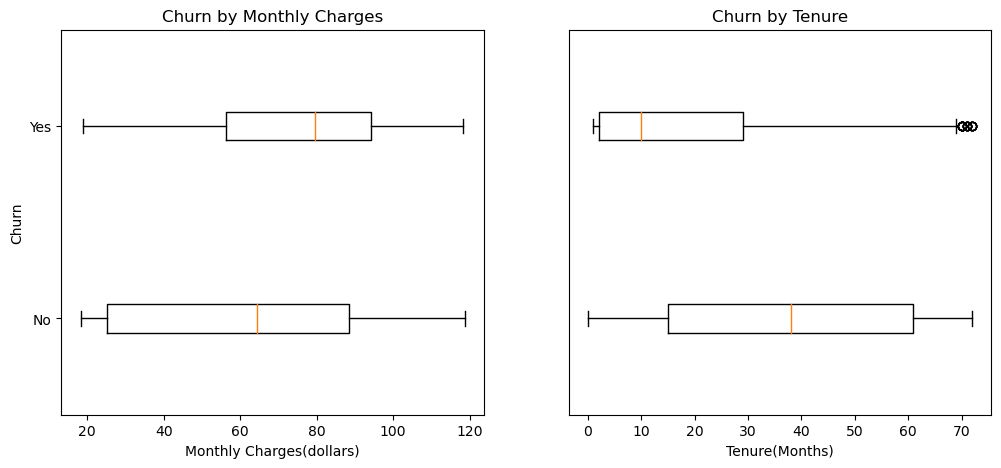

In [10]:
plt.rcParams['figure.figsize'] = [12, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)

monthly = {'No':churn[churn["Churn"] == 'No'].MonthlyCharges, 
           'Yes':churn[churn["Churn"] == 'Yes'].MonthlyCharges}


tenure = {'No':churn[churn["Churn"] == 'No'].tenure, 
           'Yes':churn[churn["Churn"] == 'Yes'].tenure}

ax1.boxplot(monthly.values(), vert=False)
ax1.set_yticklabels(monthly.keys())
ax1.set_ylabel('Churn')
ax1.set_xlabel('Monthly Charges(dollars)')
ax1.set_title('Churn by Monthly Charges')



ax2.boxplot(tenure.values(), vert=False)
ax2.set_yticks([])
ax2.set_xlabel('Tenure(Months)')
ax2.set_title('Churn by Tenure');

From the two quantitative variables we can see that customer churn tends to occur with customers who have higher monthly charges and who have not been with Telco for very long. Of course, it's important to note that this is on average as the company does still experience churn with customers with low monthly charges who have been with the company for a long time

## Data Prepocessing and Splitting the Data
Next we will need to import some libraries in order to split the dataset up and preprocess the data. Since the machine learning algorithm requires numeric values we need to encode our data. We will be using LabelEncoder and OrdinalEncoder From scikit-lean (LabelEncoder is used for encoding the tartget variable - customer churn, while OrdinalEncoded is used for converting our features). One thing we need to be careful about is to not convert 

In [11]:
from sklearn.model_selection import train_test_split

seed = np.random.randint(1,1000000)
np.random.seed(seed)
initial_train_X, initial_test_X, initial_train_y, initial_test_y = train_test_split(X, y, test_size=0.4)

In [12]:
# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Function for converting the categorical values to numerics to prepare for the ML algorithm

def convert_to_value(X, y):
    inputs = OrdinalEncoder()
    inputs.fit(X)
    outputs = LabelEncoder()
    outputs.fit(y)
    X_val = inputs.transform(X)
    y_val = outputs.transform(y)
    return X_val, y_val

In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training and testing dataset (seed set the same as above so as to assign in the same fashion)
np.random.seed(41623)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4)

# Use the function convert the test and training datasets
test_X_cd, test_y_cd = convert_to_value(test_X, test_y)
train_X_cd, train_y_cd = convert_to_value(train_X, train_y)

# Full Models
In the following section, we will test the four models using all of the features contained in our dataset (except for the two that we removed at the start). The 4 models that we will be using are:

- Naive Bayes
- Logistic Regression
- Decision Trees
- Random Forest

All four of these models are used for classifying categorical predictors and are examples of supervised learning (i.e. they require labeled inputs and outputs). 

### Naive Bayes - Full Model

 The Naive Bayes model is a relatively simple technique for classifying observations based upon Thomas Bayes' famous formula:

$$ P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$


This conditional probability is used to assign labels to observations based on the likelihood of each label according to feature data. In our case, since we are trying to determine whether or not customer churn occurs, we essentially have two conditional probabilities for each observation, in which we compare whether it's more likely (using the likelihood ratio the two labels) that cusomter churns or does not churn based on the feature data for that observation. Below we fit the Naive Bayes full model to the training data and then run it on the testing data and create a confusion matrix to assess how well the model performed. An example of what is told in a confusion matrix is shown below.

- True negative: when the model correctly identifies no churn
- False negative: when the model incorrectly predicts no churn, but churn occurs
- True positive: when the model correctly identifies churn
- False positive: when the model incorrectly predicts churn, but no churn occurs

Text(0, 0, 'True Positive')

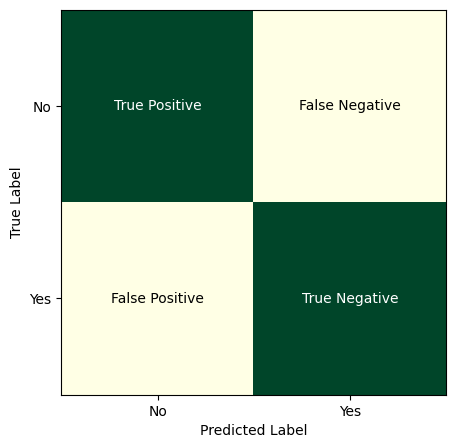

In [14]:
fig, ax = plt.subplots()
ax.imshow([[5,1],[1,5]], cmap = 'YlGn')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.text(1,1, 'True Negative', ha="center", va="center", color="w")
ax.text(0,1, 'False Positive', ha="center", va="center", color="k")
ax.text(1,0, 'False Negative', ha="center", va="center", color="k")
ax.text(0,0, 'True Positive', ha="center", va="center", color="w")


The accuracy of the Naive Bayes model with all features is 73.6%
The sensitivity is 70.0% and the specificity is 75.0%


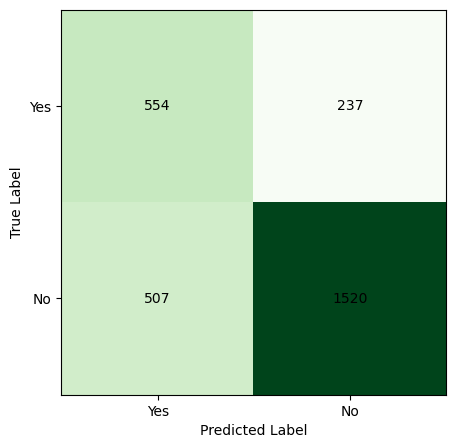

In [15]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

model = BernoulliNB()
model.fit(train_X_cd, train_y_cd)
predictions = model.predict(test_X_cd)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        

acc_fm_nb = round(model.score(test_X_cd, test_y_cd)*100,1)
sens_fm_nb = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_fm_nb = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_fm_nb))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_fm_nb, spec_fm_nb))

The accurary of the model was 73.6%, which means that it accurately predicted whether a customer would churn or not roughly three out of four times based on the data we had on them. The accuracy of the model is computed using all four of the quadrants from the confusion matrix and the formula is

$$ \text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}, $$

which means it caculculates how many correct predictions the model made. A couple of other important metrics are:

$$ \text{Sensitivity} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}, $$

which is used for determining how well the model was at correctly identifying positive results (customer churn). This is also a conditional probability that tells us what the probability of correctly identifying customer churn given that the customer will churn.


$$ \text{Specificity} = \frac{\text{True Negative}}{{\text{True Negative} + \text{False Positive}}} $$

which is used for determining how well the model was at correctly identifying negative results (no customer churn). This is also a conditional probability which tells us the probability that a customer will not churn given that they don't churn.

The Naive Bayes model is okay at identifying true positives with a sensitivity of 70%, which means that a customer that churns will be properly identified as churning 70% of the time by this model. Specificity was higher at 75%, meaning that it did a better job at identifying customer who did not churn than those that did.

We can also plot an ROC curve to visualize true positive rate(sensitivity) against false positive rate below where

$$ \text{False Positive Rate} = \frac{\text{False Positive}}{{\text{True Negative} + \text{False Positive}}}. $$

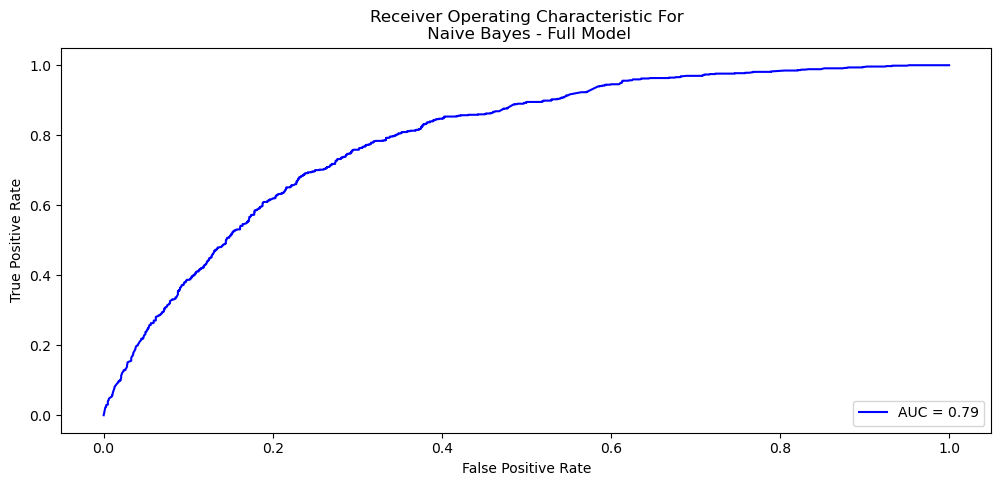

In [16]:
from sklearn import metrics

predict_prob = model.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

The ROC curve plots the true positve rate (TPR) against false positive rate (FPR) at different decision thresholds and gives an idea of how good the model is at discerning true positives from false positives. Different points along the curve represent the different thresholds - e.g. the bottom left where TPR and FPR are both 0, represents a threshold that is so strict with assigning positives, that no observations are labeled positive while at the other end where both are 1, it represents a threshold where all observations are labeled positive. Ideally, we want a steep curve the approaches a TPR of 1 quickly before FPR grows too much. Area under the curve (AUC) tells us just how well that occurs with a value of 1 meaning the model can perfectly discern false positives from true positives and an AUC of 0.5 meaning the model performs just a well as a random guess (essentially a 50% of discerning false from true positive). An AUC of less than 0.5 indicates the model actually does worse than a random guess.

In this case, the model performs relatively well with an AUC just under 0.8. Another way of interpretting this value is that it is the probability that the model will correctly identify which is which if we were to give it a randomly selected positive observation and randomly chosen negative observation. Essentially, given a customer who churned and customer who didn't, this model should be able to guess which is which 4 out of 5 times, which isn't too bad

### Logistic Regression - Full Model

A logistic regression model is a statistical model used when the response variable is categorical. Like a linear regression model, a logistic regression model can take both categorical and quantitative predictors but unlike linear regression (where the response is continuous), a logistic regression model's response is categorical (binary in this case). Logistic regression depends on the idea of generalized linear models which is a generalization of linear regression and enables the systematic part of the regression equation $$ \beta_{o}+ \beta_{1}x $$ to be connected with response via a link function. In linear regression, the link function is the identity function, while in logistic regression it is the logit function, which restricts the response to values between 0 and 1 and allows - in our case, values closer to 0 get labeled no churn, while values closer to 1 get labeled churn.

The accuracy of the Naive Bayes model with all features is 79.0%
The sensitivity is 46.4% and the specificity is 91.8%


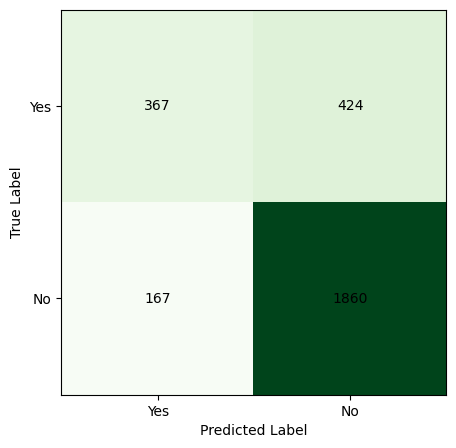

In [17]:
from sklearn import linear_model

# The full model with no variables removed - but all features have been 
# transformed into categorical features

from sklearn import linear_model
reg = linear_model.LogisticRegression(max_iter=1000)
reg.fit(train_X_cd, train_y_cd)
predictions = reg.predict(test_X_cd)


mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
acc_fm_lr = round(reg.score(test_X_cd, test_y_cd)*100,1)
sens_fm_lr = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_fm_lr = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_fm_lr))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_fm_lr, spec_fm_lr))

The logistic regression model is a bit more accurate than the Bayesian model and it's specificity is much better but this of course comes at the cost of sensitivity. The model looks to tend towards assigning no churn labels and as a result, does not have a very good true positive rate. Whether this model would be useful would really depend on how important it is to identify true positives.

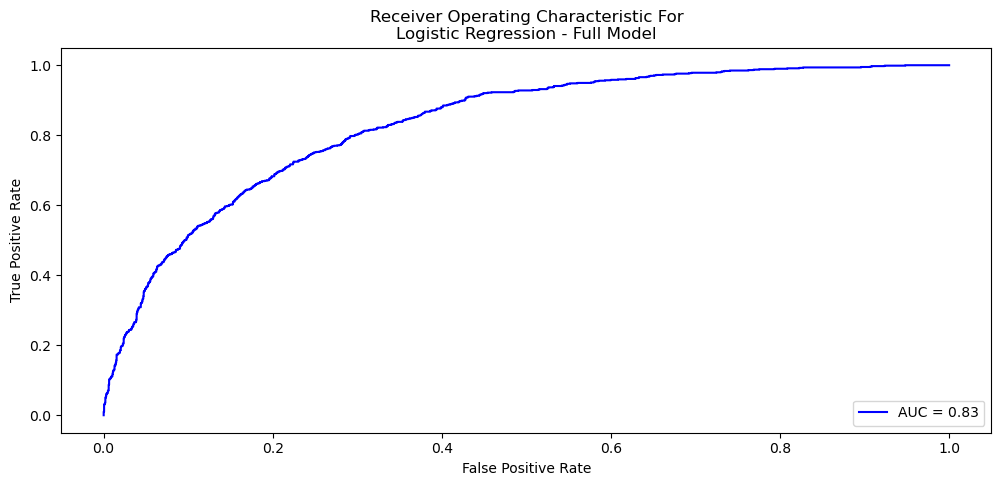

In [18]:
predict_prob = reg.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nLogistic Regression - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Trees - Full Model


The accuracy of the Naive Bayes model with all features is 76.4%
The sensitivity is 46.4% and the specificity is 91.8%


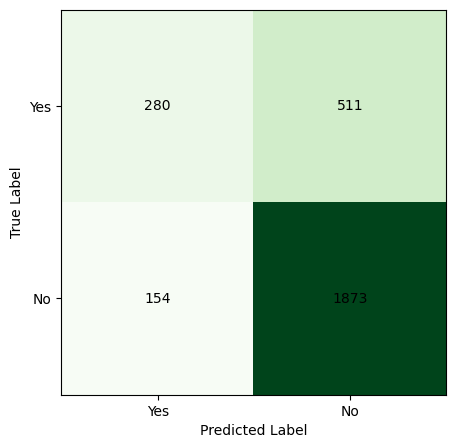

In [19]:
from sklearn.tree import DecisionTreeClassifier 

# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(train_X_cd, train_y_cd)

predictions = tree.predict(test_X_cd)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
        
acc_fm_dt = round(tree.score(test_X_cd, test_y_cd)*100,1)
sens_fm_dt = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_fm_dt = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_fm_dt))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_fm_lr, spec_fm_lr))

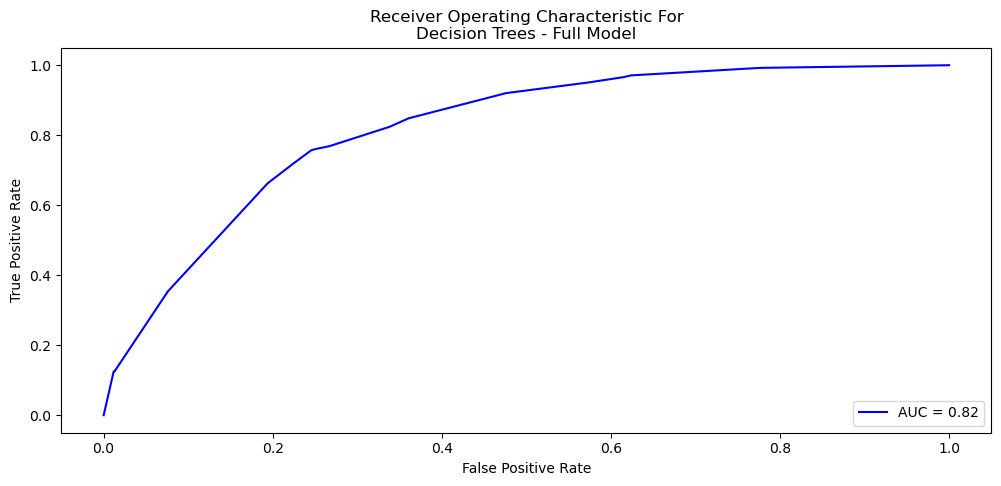

In [20]:
predict_prob = tree.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nDecision Trees - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forests - Full Model

The accuracy of the Naive Bayes model with all features is 77.8%
The sensitivity is 46.4% and the specificity is 91.8%


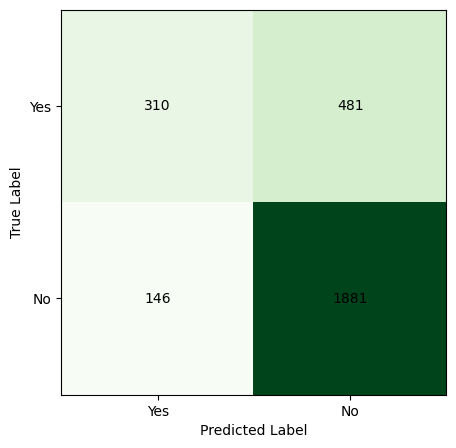

In [21]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees
bag.fit(train_X_cd, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(test_X_cd)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
        
acc_fm_rf = round(bag.score(test_X_cd, test_y_cd)*100,1)
sens_fm_rf = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_fm_rf = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_fm_rf))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_fm_lr, spec_fm_lr))

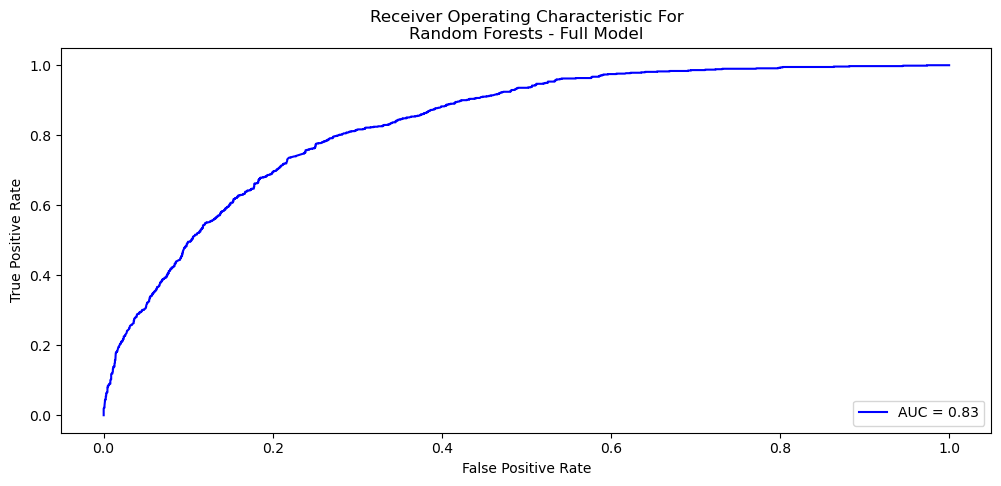

In [22]:
predict_prob = bag.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nRandom Forests - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

# Feature Selection using Chi-Square Test

We'd like to also compare how well the models perform with all of the features included in the model compared to how they perform with a reduced number of features. For feature selection, we used the chi-square criteria. This method of feature selection is based on the chi-square test, which is used to determine independence between two events. In a chi-square test, we set up a contingency table between two events with the true values in the table and compare it to another contingency table with expected values in each cell, assuming that the two events are indenpendent. From these two tables and their differences we are able to derive a chi-square test statistic which we use to determine if the two are independent or not.

For feature selection, we run a chi-square test between the response (churn) and each feature; those that are deemed to be independent of churn are removed, while those that are deemed dependent are retained. After plotting the chi-square test results by feature, we decided to retain 4 features in our model: MonthlyCharges, Contract, TechSupport and Tenure. After selecting these four features, we then repeat the four models from above.

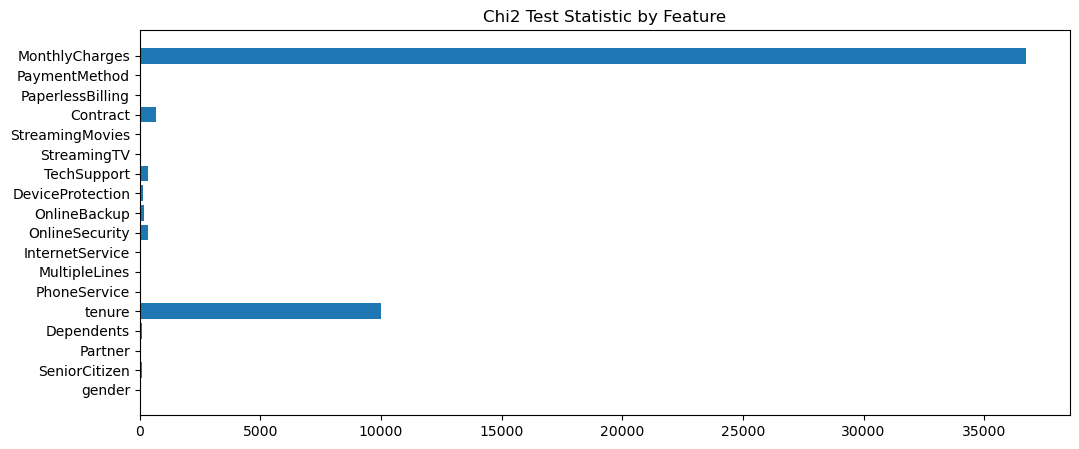

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Using chi2 to score features and select the k top features
# Set the selection criteria to k = 4 features selected using Chi2 
def chi2_features(train_X, train_y, test_X):
    select = SelectKBest(score_func=chi2, k=4)
    select.fit(train_X, train_y)
    train_X_selection = select.transform(train_X)
    test_X_selection = select.transform(test_X)
    return train_X_selection, test_X_selection, select

# Using the function above to select the most important features based on the chi2 criteria
# and assigning these arrays to be inputted into the logistic regression model
X_train_select, X_test_select, chi2_select = chi2_features(train_X_cd, train_y_cd, test_X_cd)

# Print statement giving the chi2 test statistics for each feature
#for i in range(len(chi2_select.scores_)):
#    print('The feature {} has a score of {}'.format(train_X.columns[i], round(chi2_select.scores_[i], 3)))

# Bar plot showing the test statistic for each feature
plt.barh([i for i in range(len(chi2_select.scores_))], chi2_select.scores_)
plt.yticks(range(18), train_X.columns)
plt.title('Chi2 Test Statistic by Feature');

### Naive Bayes

The accuracy of the Naive Bayes model with all features is 73.1%
The sensitivity is 71.8% and the specificity is 73.6%


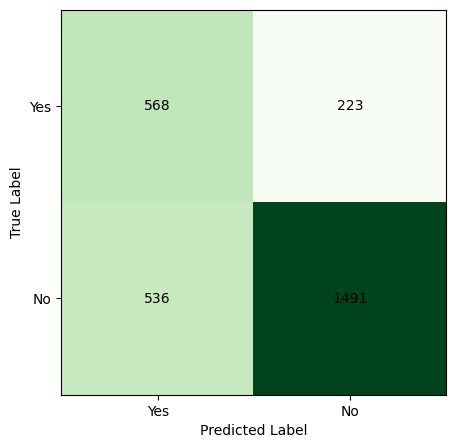

In [24]:
model = BernoulliNB()
model.fit(X_train_select, train_y_cd)
predictions = model.predict(X_test_select)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
acc_chi_nb = round(model.score(X_test_select, test_y_cd)*100,1)
sens_chi_nb = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_chi_nb = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_chi_nb))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_chi_nb, spec_chi_nb))

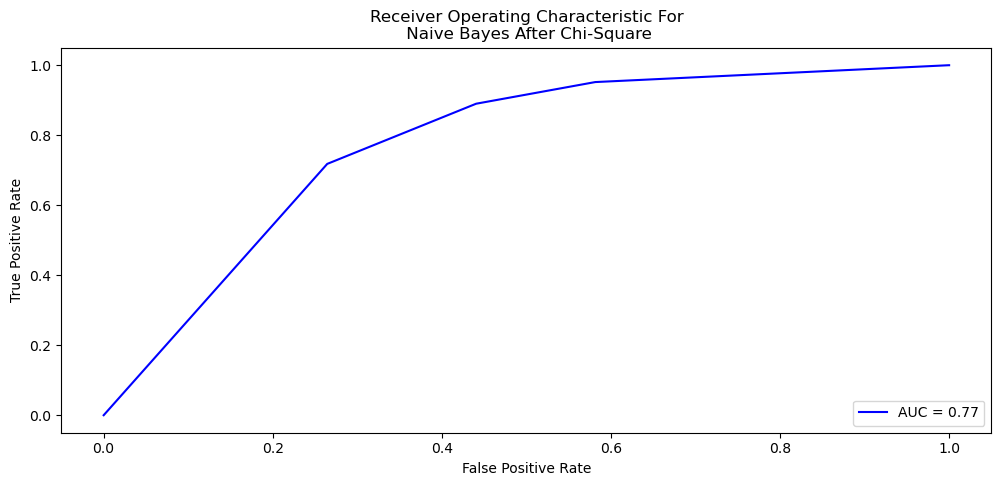

In [25]:
predict_prob = model.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression

The accuracy of the Naive Bayes model with all features is 78.3%
The sensitivity is 42.1% and the specificity is 92.4%


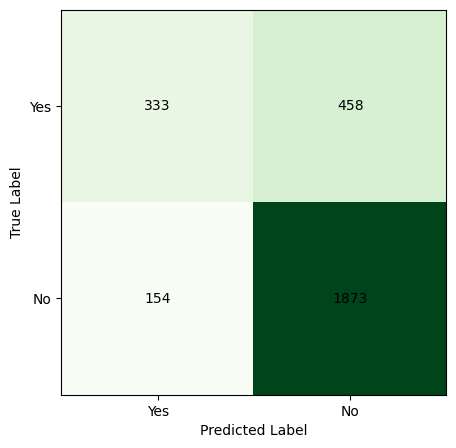

In [26]:
# Fit the logistic regression model
reg = linear_model.LogisticRegression()
reg.fit(X_train_select, train_y_cd)
predictions = reg.predict(X_test_select)

# Use the output of the function above create a dataframe of the selected features
features_c2 = chi2_select.get_support(indices=True)
features_c2_df = train_X.iloc[: ,features_c2]

# Print statement giving the accuracy of the model and which features were used

acc_chi_lr = reg.score(X_test_select, test_y_cd)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
        
acc_chi_lr = round(reg.score(X_test_select, test_y_cd)*100,1)
sens_chi_lr = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_chi_lr = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_chi_lr))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_chi_lr, spec_chi_lr))

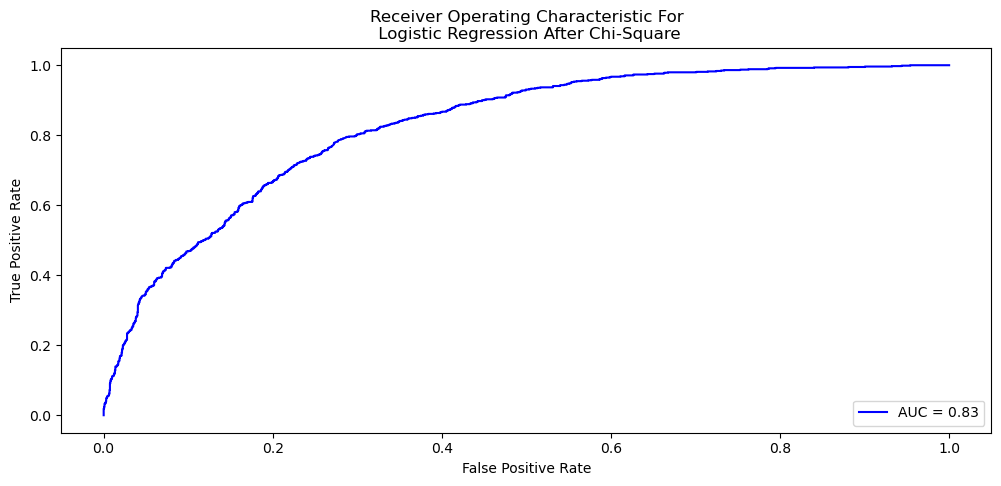

In [27]:
predict_prob = reg.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Logistic Regression After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Tree

The accuracy of the Naive Bayes model with all features is 76.4%
The sensitivity is 35.4% and the specificity is 92.4%


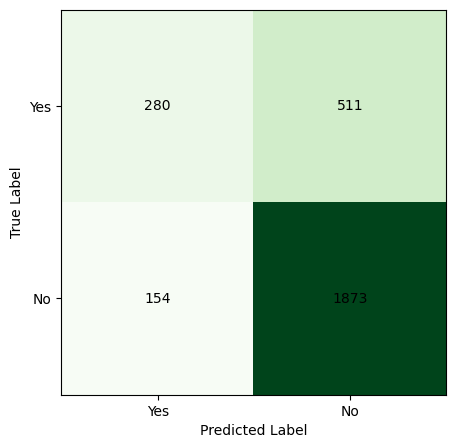

In [28]:
# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train_select, train_y_cd)

predictions = tree.predict(X_test_select)

acc_chi_dt = tree.score(X_test_select, test_y_cd)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
        
acc_chi_dt = round(tree.score(X_test_select, test_y_cd)*100,1)
sens_chi_dt = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_chi_dt = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_chi_dt))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_chi_dt, spec_chi_dt))

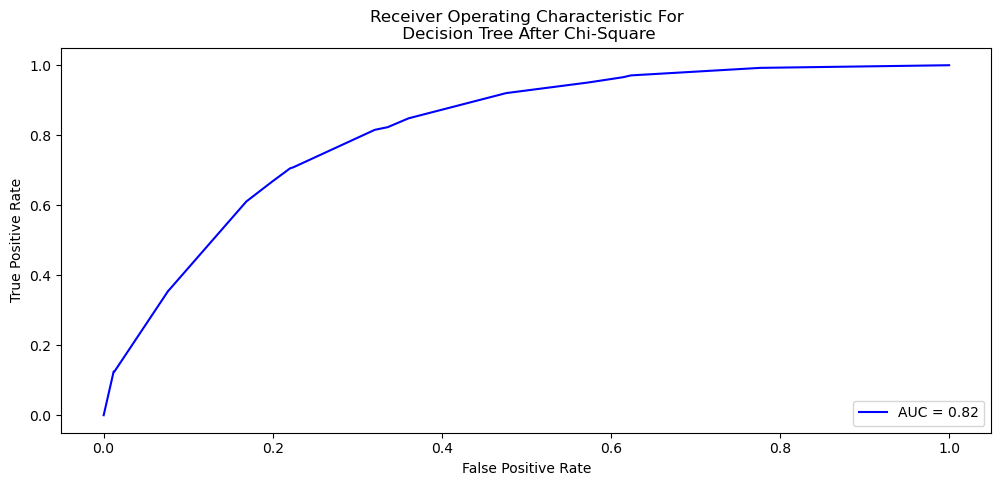

In [29]:
predict_prob = tree.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Decision Tree After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forest 

The accuracy of the Naive Bayes model with all features is 77.8%
The sensitivity is 40.1% and the specificity is 92.5%


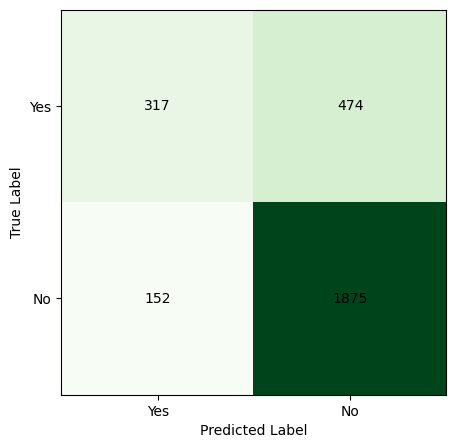

In [30]:
bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees

bag.fit(X_train_select, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(X_test_select)

mat = confusion_matrix(test_y_cd, predictions, labels = [1,0])

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'Greens')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");
        
        
        
        
acc_chi_rf = round(bag.score(X_test_select, test_y_cd)*100,1)
sens_chi_rf = round(mat[0,0]/(mat[0,1]+mat[0,0])*100,1)
spec_chi_rf = round(mat[1,1]/(mat[1,1]+mat[1,0])*100,1)   

print('The accuracy of the Naive Bayes model with all features is {}%'.format(acc_chi_rf))
print('The sensitivity is {}% and the specificity is {}%'.format(sens_chi_rf, spec_chi_rf))

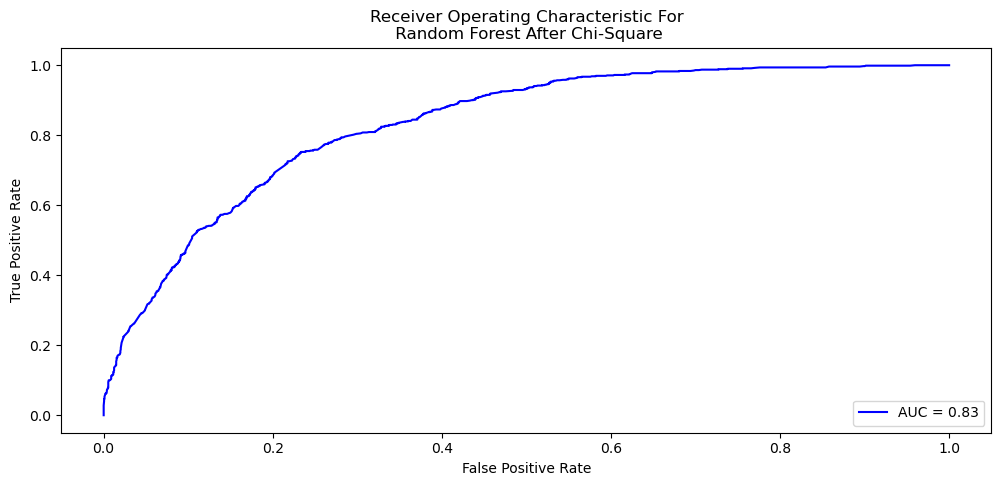

In [31]:
predict_prob = bag.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Random Forest After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

## Conclusion

We can summarize our results below to compare how the models performed and which model would likely be best.

### Full Model

In [32]:
outcome_full = pd.DataFrame([[acc_fm_nb, acc_fm_lr, acc_fm_dt, acc_fm_rf],
              [sens_fm_nb, sens_fm_lr, sens_fm_dt, sens_fm_rf],
              [spec_fm_nb, spec_fm_lr, spec_fm_dt, spec_fm_rf]],
                index= ['Accuracy', 'Sensitivity', 'Specificity'],
                columns = ['Naive Bayes', 'Logistic Regression', 'Decision Trees', 'Random Forests'])
display(outcome_full)

,Naive Bayes,Logistic Regression,Decision Trees,Random Forests
Accuracy,73.6,79.0,76.4,77.8
Sensitivity,70.0,46.4,35.4,39.2
Specificity,75.0,91.8,92.4,92.8


### Chi Squared Model

In [33]:
outcome_chi2 = pd.DataFrame([
            [acc_chi_nb, acc_chi_lr, acc_chi_dt, acc_chi_rf],
            [sens_chi_nb, sens_chi_lr, sens_chi_dt, sens_chi_rf],
            [spec_chi_nb, spec_chi_lr, spec_chi_dt, spec_chi_rf]],
                index= ['Accuracy', 'Sensitivity', 'Specificity'],
                columns = ['Naive Bayes', 'Logistic Regression', 'Decision Trees', 'Random Forests'])
display(outcome_chi2)

,Naive Bayes,Logistic Regression,Decision Trees,Random Forests
Accuracy,73.1,78.3,76.4,77.8
Sensitivity,71.8,42.1,35.4,40.1
Specificity,73.6,92.4,92.4,92.5


In terms of the full models that we compared, the naive bayes had the lowest accuracy with an accuracy of under 74%, while the other three ranged from 76-79%. The logistic regression model had the highest at 79% but it's performance was very similar to that of the decision trees and random forests models, which only differed slightly from one another. All three of these scored a specificity around 92%, with the logistic regression doing best in sensitivity with a value of 46.4%. While it may seem like the logistic regression model would be the best model based on the fact that it performs a little better than decision tree and random forests models with the 3 of them having the best accuracy, it's important to consider the objective of this model. Despite the naive Bayes model being the least accurate, it was far and away the most sensitive, which may be more important.

The purpose of these models is to help identify customer who may churn, likely so the business can take action to help prevent those customers from leaving (perhaps through a promotion or some other sort of offer). If this happens to be the case, then the other three models might not be very good for this purpose as they all scored less than 50% in sensitivity and would not be great at identifying customers who may churn. While the naive Bayes model may have more false positives, in an overall business sense, those false positives may be much less detrimental. While a false negative represents a customer that left (possibly for another phone company) without the business making any effort to keep them, a false positive represents a customer who would have stayed and may have received some sort of promotion or offer they wouldn't have otherwise. Thus, the naive Bayes may be the best model out of these four (although there may be other models more well-suited for this task)

Overall, there was very little difference between the full and reduced models and the reduction in features led to very small changes in outcome. Since the reduced number of features was able to explain the outcomes just as well as the full model, it would be best to go with the more parsimonious reduced model.
